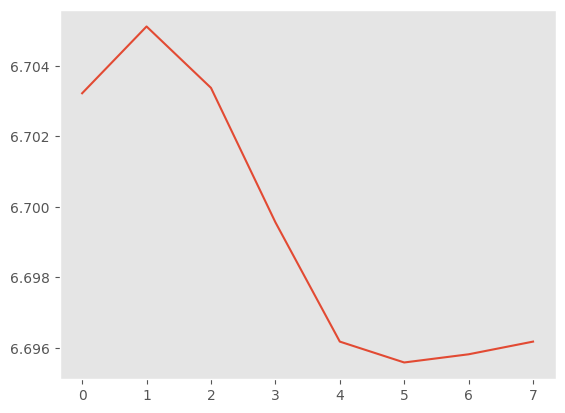

In [184]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.txt')
df.dropna(inplace=True)

n = df.shape[0]
n_dim_state = 2;

history_state_means = np.zeros((n, n_dim_state))
history_state_covs = np.zeros((n, n_dim_state, n_dim_state))

for idx, row in df.iterrows():
    if idx == 0: # Initialize the Kalman filter
        delta = 1e-9
        trans_cov = delta / (1 - delta) * np.eye(2)

        obs_mat = [df.iloc[0].CAT, 1]

        kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                          initial_state_mean=np.zeros(2),
                          initial_state_covariance=np.ones((2, 2)),
                          transition_matrices=np.eye(2),
                          observation_matrices=obs_mat,
                          observation_covariance=1.0,
                          transition_covariance=trans_cov)

        history_state_means[0], history_state_covs[0] = kf.filter(np.asarray(df.iloc[0].DOG))
        slope=history_state_means[0, 0]

    else:
        obs_mat = np.asarray([[df.iloc[idx].CAT, 1]])

        history_state_means[idx], history_state_covs[idx] = kf.filter_update(history_state_means[idx-1], 
                                                            history_state_covs[idx-1], 
                                                            observation = df.iloc[idx].DOG, 
                                                            observation_matrix=obs_mat)
        slope=history_state_means[idx, 0]

plt.figure(1)
plt.plot(history_state_means[:, 0], label="Slope")
plt.grid()
plt.show()

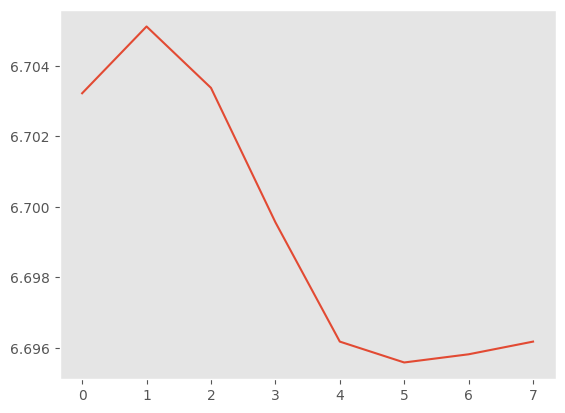

In [186]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data.txt')
df.dropna(inplace=True)

delta = 1e-9
trans_cov = delta / (1 - delta) * np.eye(2)
obs_mat = np.vstack([df.iloc[:].CAT, np.ones(df.iloc[:].CAT.shape)]).T[:, np.newaxis]

kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.zeros(2),
                  initial_state_covariance=np.ones((2, 2)),
                  transition_matrices=np.eye(2),
                  observation_matrices=obs_mat,
                  observation_covariance=1.0,
                  transition_covariance=trans_cov)

state_means, state_covs = kf.filter(df.iloc[:].DOG)

plt.figure(1)
plt.plot(state_means[:, 0], label="Slope")
plt.grid()
plt.show()

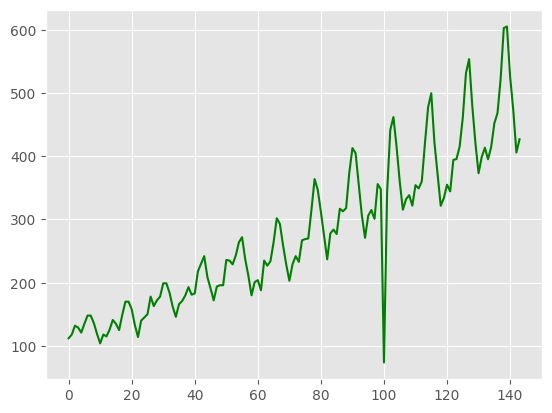

In [228]:
from pykalman import KalmanFilter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datasets import load_airline
y = load_airline()
y

def run(ys):
  burnin = 100
  kf = KalmanFilter(initial_state_mean=0, n_dim_obs=1)
  ys_train = [ [y] for y in ys[:burnin] ]
  kf = kf.em(ys_train)
  ys_test = [ [y] for y in ys[burnin:]]
  x_rest = kf.filter(ys_test)
  x_rest_flat = np.array([x[0] for x in x_rest[0]])
  XS = np.concatenate((ys[:burnin], x_rest_flat))
  return XS
    
XS = run(y.values)

import matplotlib.pyplot as plt
plt.plot(XS,'g')


In [229]:
%matplotlib inline
import sys
import copy
import datetime as dt

import pandas as pd
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt

import pcse
from pcse.models import Wofost72_WLP_FD
print("This notebook was built with:")
print(f"python version: {sys.version}")
print(f"PCSE version: {pcse.__version__}")

from dataproviders import parameters, agromanagement, weather
wofost = Wofost72_WLP_FD(parameters, weather, agromanagement)
wofost.run_till_terminate()
df = pd.DataFrame(wofost.get_output()).set_index("day")

This notebook was built with:
python version: 3.9.19 (main, Apr  6 2024, 17:57:55) 
[GCC 9.4.0]
PCSE version: 5.5.6


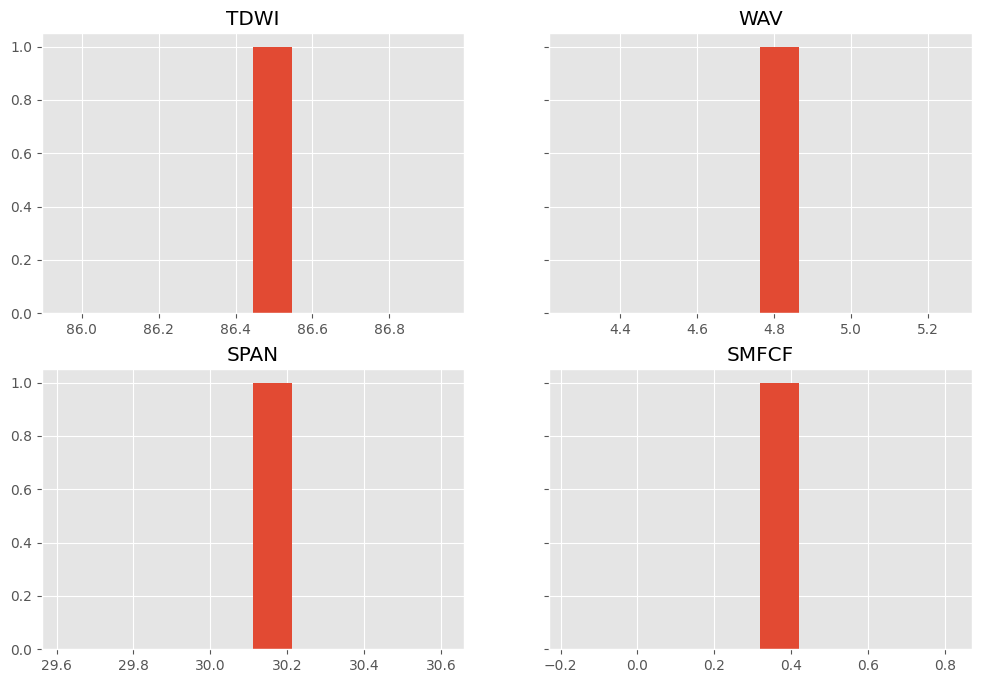

In [230]:
ensemble_size = 1
np.random.seed(10000)

# A container for the parameters that we will override
override_parameters = {}
# Initial conditions
override_parameters["TDWI"] = np.random.normal(150., 50., (ensemble_size))
override_parameters["WAV"] = np.random.normal(4.5, 1.5, (ensemble_size))
# parameters
override_parameters["SPAN"] = np.random.normal(31, 3 ,(ensemble_size))
override_parameters["SMFCF"] = np.random.normal(0.31, 0.03 ,(ensemble_size))
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8), sharey=True)
# Show the sample that was drawn
for ax, (par, distr) in zip(axes.flatten(), override_parameters.items()):
    ax.hist(distr)
    ax.set_title(par)

In [251]:
ensemble = []
for i in range(ensemble_size):
    p = copy.deepcopy(parameters)
    for par, distr in override_parameters.items():
        p.set_override(par, distr[i])
    member = Wofost72_WLP_FD(p, weather, agromanagement)
    ensemble.append(member)

preds = [
    list()
    for _ in range(ensemble_size)
]

In [252]:
show_output = True

n = len(df.index)
n_dim_state = 2
history_state_means = np.zeros((n, n_dim_state))
history_state_covs = np.zeros((n, n_dim_state, n_dim_state))
delta = 1e-100
trans_cov = delta / (1 - delta) * np.eye(n_dim_state)

filters = []
for i, day in enumerate(df.index):
    for j, member in enumerate(ensemble):
        member.run(1)
        SM = member.get_variable("SM")
        LAI = member.get_variable("LAI")
        
        if LAI is None:
            continue

        if i == 0:
            obs_mat = np.array([LAI, 1])
            kf = KalmanFilter(
                n_dim_obs=1, 
                n_dim_state=n_dim_state,      
                initial_state_mean=np.zeros(n_dim_state),
                initial_state_covariance=np.ones((n_dim_state, n_dim_state)),
                transition_matrices=np.eye(n_dim_state),
                observation_matrices=obs_mat,
                observation_covariance=.1,
                transition_covariance=trans_cov
            )
            filters.append(kf)
            history_state_means[0], history_state_covs[0] = kf.filter(np.asarray(LAI))
        else:
            obs_mat = np.asarray([[LAI, 1]])
            kf = filters[j]
            history_state_means[i], history_state_covs[i] = kf.filter_update(
                history_state_means[i - 1], 
                history_state_covs[i - 1], 
                observation = LAI, 
                observation_matrix=obs_mat
            )
 

In [253]:
results = [pd.DataFrame(member.get_output()) for member in ensemble]

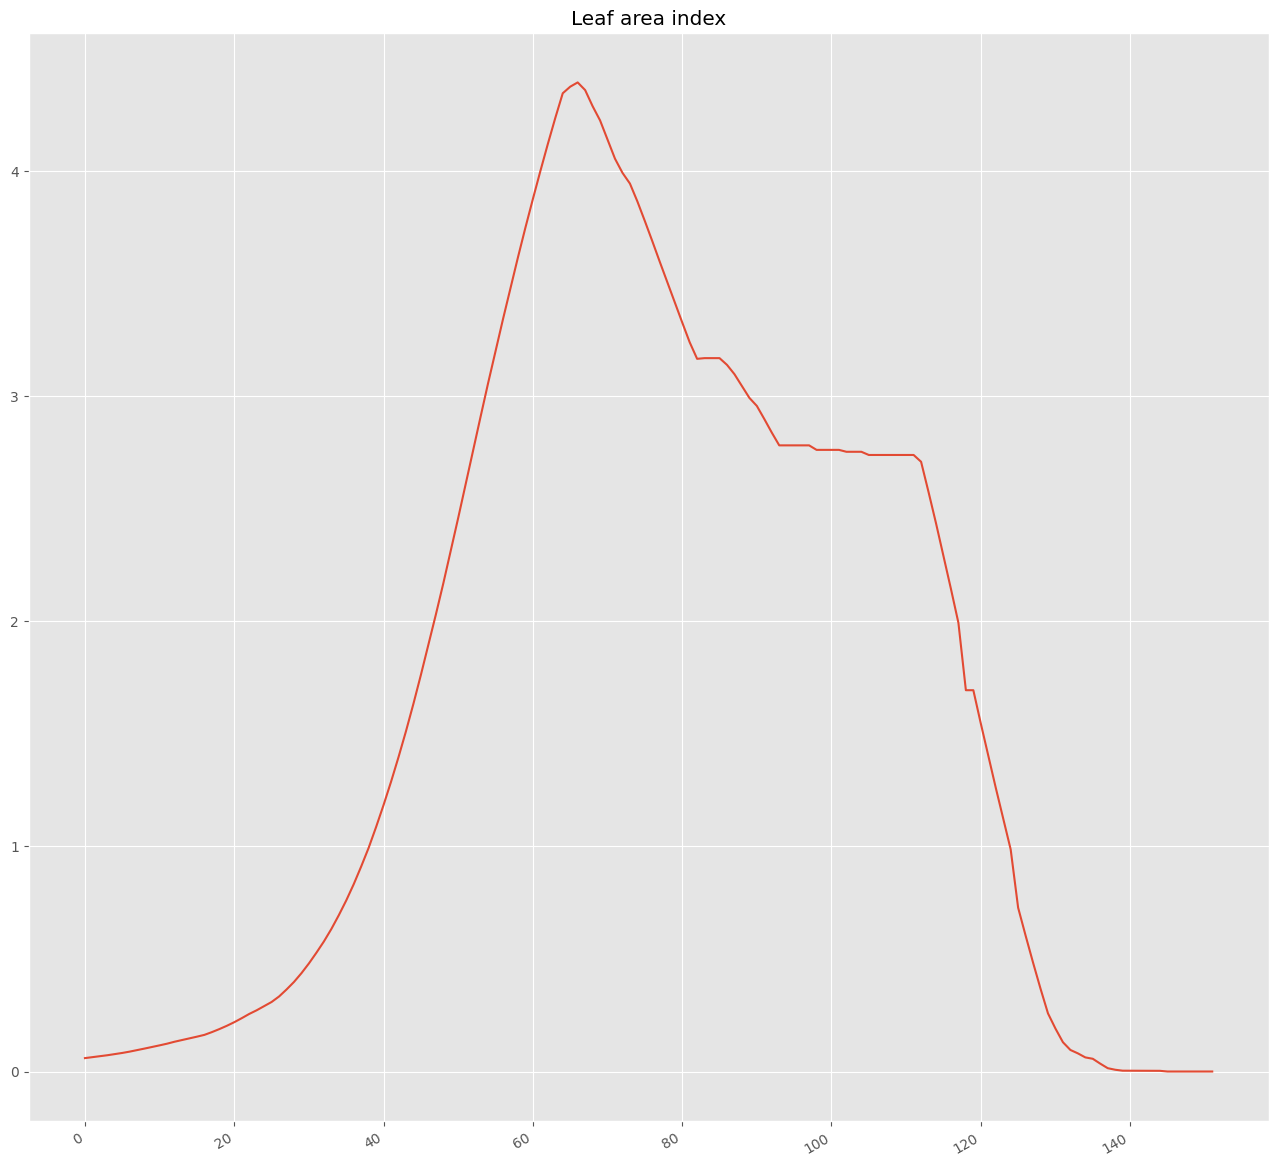

In [254]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,16), sharex=False)
for i, member_df in enumerate(results):
    pred_df = pred_dfs[i]
    member_df["LAI"].plot(ax=ax)
ax.set_title("Leaf area index")
fig.autofmt_xdate()

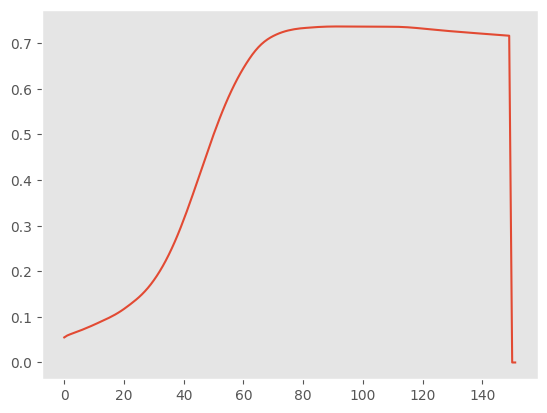

In [255]:
plt.figure(1)
plt.plot(history_state_means[:, 0], label="Slope")
plt.grid()
plt.show()